## Data Augmentation: Evaluate

In [ ]:
import os
import sys

# Needed to import modules from parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_from_disk
from sklearn.metrics import accuracy_score
import random
import numpy as np
import torch
import os

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Random Seed for Reproducibility

In [2]:
# Set a seed for random module
random.seed(42)

# Set a seed for numpy module
np.random.seed(42)

# Set a seed for torch module
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define Parameters

In [3]:
topic = "cannabis"

In [4]:
model_name = "deepset/gbert-large"

In [5]:
# Define training arguments
TRAINING_ARGS = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',            # directory for storing logs
    logging_strategy="steps",        # log training loss every specified number of steps
    logging_steps=200,                # number of steps to log training loss
    evaluation_strategy="steps",     # evaluate model after a specified number of steps
    eval_steps=200,                   # number of steps to evaluate model
)

## Load Dataset

In [6]:
dataset = load_from_disk(f"../../data/tmp/augmented_dataset_{topic}_word_replacement")
dataset

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id'],
        num_rows: 2651
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id'],
        num_rows: 295
    })
    positive_sampled: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id'],
        num_rows: 265
    })
    expanded_1: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id'],
        num_rows: 265
    })
    expanded_2: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id'],
        num_rows: 530
    })
    expanded_3: Data

## Train Models

In [7]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

In [8]:
datasets_splits = ['positive_sampled', 'expanded_1', 'expanded_2', 'expanded_3', "train"]#, #'expanded_4', 'expanded_5']

negative_samples = dataset["train"].filter(lambda x: x['label'] == 0)

In [9]:
from datasets import concatenate_datasets
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch import nn

In [10]:
def balance_and_discard_classes(dataset, label_column='label'):
    """ Balance the dataset by randomly sampling the same number of examples for each class."""
    
    # Aggregate indices by class
    class_indices = {label: [i for i, example in enumerate(dataset) if example[label_column] == label] 
                     for label in set(dataset[label_column])}
    
    # Determine the size of the smallest class for balancing
    min_class_size = min(len(indices) for indices in class_indices.values())
    
    # Randomly sample indices from each class to match the smallest class size
    balanced_indices = [index for indices in class_indices.values() for index in random.sample(indices, min_class_size)]
    random.shuffle(balanced_indices)
    
    # Determine discarded indices by finding the difference between all indices and the balanced ones
    all_indices = set(range(len(dataset)))
    discarded_indices = list(all_indices - set(balanced_indices))
    
    # Select the balanced and discarded indices to create new datasets
    balanced_dataset = dataset.select(balanced_indices)
    discarded_dataset = dataset.select(discarded_indices)
    
    return balanced_dataset, discarded_dataset

In [11]:
# balanced_dataset, discarded_dataset = balance_and_discard_classes(dataset, 'label')

# print(f"Balanced dataset size: {len(balanced_dataset)}")
# print(f"Discarded dataset size: {len(discarded_dataset)}")

In [12]:
def get_predictions(tokenized_datasets, tokenizer, model, device):
    """Use the trained model to make predictions on the test set."""
    
    preds = []
    labels = []
    for row in tokenized_datasets:
        # Encode the text inputs
        inputs = tokenizer(row["text"], return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            # Forward pass
            outputs = model(**inputs.to(device))
            # Apply softmax to logits to get probabilities
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            # Get the predicted class (the one with the highest probability)
            predicted_class = torch.argmax(predictions).item()
        
        # Store the predictions and labels
        preds.append(predicted_class)
        labels.append(row["label"])
    
    return preds, labels

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calc_metrics(labels, preds):
    """
    Calculates the accuracy, precision, recall, and F1 score for the given labels and predictions and returns them in a dictionary.
    """
    
    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='binary'),
        'recall': recall_score(labels, preds, average='binary'),
        'f1': f1_score(labels, preds, average='binary'),
    }

    return metrics


In [14]:
from collections import Counter


eval_result_list = {}

for split in datasets_splits: #----------------------------------------------------------------------
    
    print(f"Loading dataset for {split}")

    ################################## COMPILE DATASET ##################################
    
    if split == 'positive_sampled':
        dataset_augmented = concatenate_datasets([negative_samples, dataset[split]])
    elif split == 'train':
        dataset_augmented = dataset["train"] 
    else:
        positive_sampled = dataset["positive_sampled"] 
        generated_samples = dataset[split]
        dataset_augmented = concatenate_datasets([negative_samples, positive_sampled, generated_samples])
        print("Dataset generated samples", len(generated_samples))
    
    ################################## Balance Classes ##################################
    
    dataset_augmented, _ = balance_and_discard_classes(dataset_augmented, 'label')
    label_counts = Counter(dataset_augmented['label'])
    print("Dataset size", len(dataset_augmented))
    print("Class frequencies:", label_counts)
    
    ################################## Load Model ##################################
    
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    ################################## Tokenize Dataset ##################################
    
    # Tokenize dataset
    tokenized_dataset_train = dataset_augmented.map(lambda examples: 
        tokenizer(examples["text"], padding="max_length", truncation=True), 
        batched=True)
    
    tokenized_dataset_test = dataset["test"].map(lambda examples: 
        tokenizer(examples["text"], padding="max_length", truncation=True), 
        batched=True)
    
    # Shuffle both datasets
    tokenized_dataset_train = tokenized_dataset_train.shuffle(seed=42)
    tokenized_dataset_test = tokenized_dataset_test.shuffle(seed=42)
    
    ################################## Class Weights ##################################

    # Calculate class weights inversely proportional to class frequencies
    labels = dataset_augmented['label']
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
    print("Class weights",class_weights_tensor)
    
    ################################## Train Model ##################################
    
    class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False):
            labels = inputs.get("labels")
            # forward pass
            outputs = model(**inputs)
            logits = outputs.get('logits')
            # compute custom loss
            loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
            return (loss, outputs) if return_outputs else loss

    # Create a Trainer object
    trainer = Trainer(
        model=model,
        args=TRAINING_ARGS,
        train_dataset=tokenized_dataset_train,
        eval_dataset=tokenized_dataset_test,
        compute_metrics=compute_metrics
    )
    
    # Train the model
    trainer.train()
    
    ################################## EVALUATE ##################################
    
    # Evaluate the model
    eval_results = trainer.evaluate(tokenized_dataset_test)
    print("Eval Results:", eval_results)  
    
    # Use the trained model to make predictions on the test set
    preds, labels = get_predictions(tokenized_dataset_test, tokenizer, model, "cuda")
    metrics = calc_metrics(labels, preds)
    eval_result_list[split] = metrics
    
    ################################## Save MODEL ##################################
    
    # # Save the model
    # local_path = f"../models/{model_name.replace('/','_')}_{topic}_model"
    # trainer.save_model(local_path)
    # tokenizer.save_pretrained(local_path)
    
     ################################## CLEAR GPU ##################################
     
    # Clear GPU memory to avoid memory errors
    del model, tokenizer, tokenized_dataset_test, tokenized_dataset_train, trainer
    torch.cuda.empty_cache()
        

Loading dataset for positive_sampled
Dataset size 1589
Class frequencies: Counter({1: 265, 0: 265})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 530/530 [00:00<00:00, 2919.69 examples/s]


Class weights tensor([1., 1.])


/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


Eval Results: {'eval_loss': 0.236639603972435, 'eval_accuracy': 0.9254237288135593, 'eval_runtime': 13.8001, 'eval_samples_per_second': 21.377, 'eval_steps_per_second': 2.681, 'epoch': 2.0}


In [15]:
print(eval_result_list)

{'positive_sampled': {'accuracy': 0.9254237288135593, 'precision': 0.9133333333333333, 'recall': 0.9383561643835616, 'f1': 0.9256756756756757}}


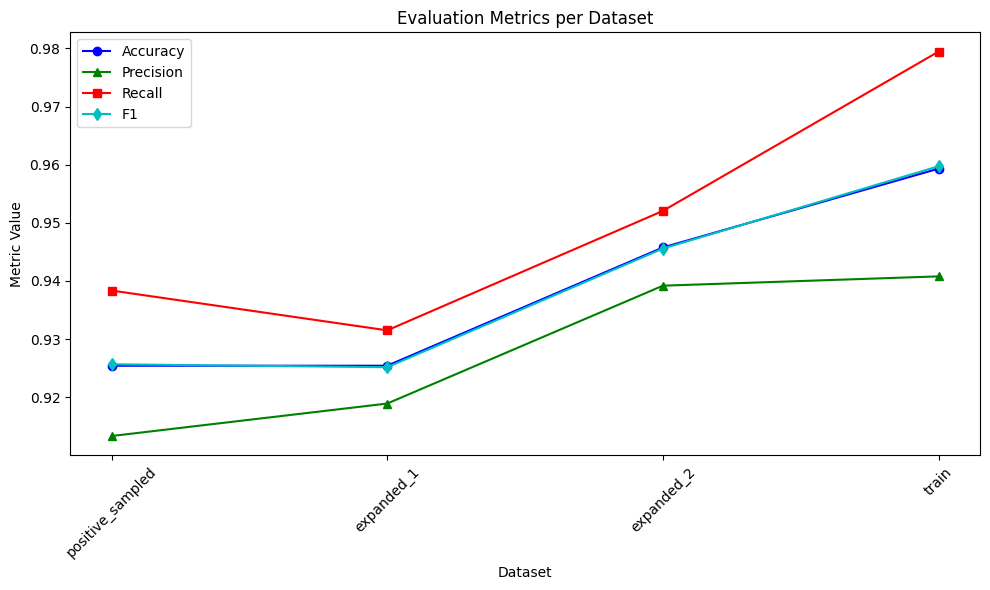

In [10]:
import matplotlib.pyplot as plt
from itertools import cycle

#Example dictionary with evaluation results per dataset
results = {
'positive_sampled': {'accuracy': 0.9254237288135593, 'precision': 0.9133333333333333, 'recall': 0.9383561643835616, 'f1': 0.9256756756756757}, 'expanded_1': {'accuracy': 0.9254237288135593, 'precision': 0.918918918918919, 'recall': 0.9315068493150684, 'f1': 0.9251700680272109}, 'expanded_2': {'accuracy': 0.9457627118644067, 'precision': 0.9391891891891891, 'recall': 0.952054794520548, 'f1': 0.9455782312925171},  'train': {'accuracy': 0.9593220338983051, 'precision': 0.9407894736842105, 'recall': 0.9794520547945206, 'f1': 0.959731543624161}}


#results = eval_result_list

metrics = list(results[next(iter(results))].keys())
datasets = list(results.keys())

# Extendable setup for plotting
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])  # Add more colors if needed
markers = cycle(['o', '^', 's', 'd', 'p', '*', 'x'])  # Add more markers if needed

plt.figure(figsize=(10, 6))
for metric in metrics:
    metric_values = [results[dataset][metric] for dataset in datasets]
    plt.plot(datasets, metric_values, marker=next(markers), color=next(colors), label=metric.capitalize())

plt.xlabel('Dataset')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics per Dataset')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Save and Output Results

In [17]:
from tabulate import tabulate

In [18]:
import json

# Define the file path to save the dictionary
file_path = f"eval_results_da_wr_{topic}.json"

# Save the dictionary to disk as JSON
with open(file_path, "w") as file:
    json.dump(eval_results, file)


In [4]:
import json

# Define the file path where the JSON data is saved
file_path = f"eval_results_da_wr_{topic}.json"

# Load the dictionary from the JSON file
with open(file_path, "r") as file:
    eval_results = json.load(file)


In [6]:
eval_results

{'eval_loss': 0.16313880681991577,
 'eval_accuracy': 0.9593220338983051,
 'eval_runtime': 13.715,
 'eval_samples_per_second': 21.509,
 'eval_steps_per_second': 2.698,
 'epoch': 2.0}